# Word2vec

Another method to find company embeddings is to use word2vec. How it works and how we aim to use is explained below.

## How it works

Imagine I have two sentences:
- "Formula One driver Lewis Hamilton is a seven time world champion". 
- "Ferrari driver Sebastian Vettel fails to qualify for the fifth Grand Prix in a row"

Say I want find words that are semantically related to Lewis.

<!-- We can represent "Lewis" with [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], where the first 11 words are from the first sentence, and the last 14 words are from the second sentence. -->

In word2vec we can use two different algorithms, continuous bag of words (CBOW) and skip-gram negative sampling. 

![image.png](../images/w2v_1.png)

### Continuous bag of words (CBOW)

We take a window of n words surrounding "Lewis" and use those words as input into a neural network, using the logic that if certains words appear together often, then they're most likely semantically related. We take these surrounding words and plug them into a neural network to train weights which predict "Lewis".

We plug in a one hot vector for each word in the window and train the hidden layer to output probabilities of the current word ("Lewis"). Therefore the order of the words do not matter, just what the words are.

![image.png](../images/w2v_2.png)

### Skip Gram Negative Sampling

Whereas, in the second option of using the continuous skip-gram architecture; the model uses the current word to predict the surrounding window of context words. The skip-gram architecture weighs nearby context words more heavily than more distant context words. The output probabilities are going to relate to how likely it is to find each vocabulary word near our input word. For example, if you gave the trained network the input word “Europe”, the output probabilities are going to be much higher for words like “Belgium” and “Continent” than for unrelated words like “fruits” and “cats”.

## How we will use it

We will first run all the words in each annual report through the word2vec neural network in order to extract a matrix of word embeddings, where each word is theoretically close to semantically related words. We then take a subset of these word embeddings of only words that belong in a given company filing, and average them. This produces a pseudo-document vector which theoretically represents these companies semantically.

## Lets get to the code!

First we need to load in the functions and data:

In [1]:
import os
import json
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/preprocessed.csv")

Here we split each document converted into word vectors.

In [2]:
from gensim.models.word2vec import Word2Vec
from gensim import utils

bd_processed = df["coDescription_stopwords"].apply(lambda x: utils.simple_preprocess(x))
bd_processed.head()

0    [mongodb, leading, modern, general, purpose, d...
1    [salesforce, global, leader, customer, relatio...
2    [splunk, provides, innovative, software, solut...
3    [okta, leading, independent, provider, identit...
4    [veeva, leading, provider, industry, cloud, so...
Name: coDescription_stopwords, dtype: object

Now lets build the Word2Vec model! Due to the sheer amount of computation required, we will limit wach word vector produced to just 200 dimensions. Studies have shown that increasing this size beyond 200 - 300 does not bring much measurable benefit.

In [3]:
model_w = Word2Vec(bd_processed, vector_size=200)

We can examine words and see which words are most similar. Below are the most similar words to `cloud`, `trial`, and `oil`.

In [4]:
model_w.wv.most_similar(positive =['cloud'], topn = 5)

[('computing', 0.8406844139099121),
 ('saas', 0.8340073823928833),
 ('server', 0.8202986121177673),
 ('oracle', 0.8158725500106812),
 ('analytics', 0.806252658367157)]

In [5]:
model_w.wv.most_similar(positive =['trial'], topn = 5)

[('study', 0.799735963344574),
 ('clinicaltrial', 0.6893743872642517),
 ('clinicaltrials', 0.6798008680343628),
 ('trialin', 0.6414549946784973),
 ('superiority', 0.6358104944229126)]

In [6]:
model_w.wv.most_similar(positive =['oil'], topn = 5)

[('natural', 0.644670307636261),
 ('extractive', 0.6383910775184631),
 ('oiland', 0.6209254264831543),
 ('flared', 0.5451371073722839),
 ('greenhouse', 0.544670581817627)]

Now we'll map these word vectors back to each document, by averaging all the word vectors that belong to words in a given document (filing)

In [7]:
def doc_to_vec(text):
    word_vecs = [model_w.wv[w] for w in text if w in model_w.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(model_w.vector_size)
    
    return np.mean(word_vecs, axis = 0)

doc_vec = pd.DataFrame(bd_processed.apply(doc_to_vec).tolist())
labels = np.asarray(model_w.wv.index_to_key)

If you're interested, the entire 200 dimensions of each document is below:

In [8]:
doc_vec

0         1         2         3         4         5         6    \
0   -0.266430  0.058570  0.133250 -0.240755  0.031110  0.354272 -0.030071   
1   -0.243842  0.073087  0.128496 -0.320603  0.031031  0.315037 -0.029315   
2   -0.201449 -0.052754  0.106328 -0.286611  0.061125  0.304068 -0.040573   
3   -0.261207  0.021259  0.112457 -0.271841  0.171435  0.385964 -0.088941   
4   -0.148426 -0.156518 -0.143092 -0.110709  0.172356  0.113533 -0.297073   
..        ...       ...       ...       ...       ...       ...       ...   
670 -0.035235 -0.002221 -0.199545 -0.008108  0.240923  0.157205 -0.263923   
671 -0.339501 -0.278169  0.140422  0.358072  0.080469 -0.111862 -0.006765   
672 -0.062150 -0.360614 -0.411228 -0.125893  0.208282 -0.035564 -0.371987   
673 -0.250950 -0.061647 -0.082210  0.052555  0.255154 -0.013726 -0.149616   
674 -0.185747  0.062041  0.202281 -0.358539 -0.081141  0.294580 -0.029432   

          7         8         9    ...       190       191       192  \
0   -0.393737  0.107081 -0.187045  ... -0.160261  0.169007 -0.248586   
1   -0.492052  0.166525 -0.271861  ... -0.169705  0.139413 -0.256655   
2   -0.403209  0.274189 -0.219767  ... -0.210574  0.246620 -0.233868   
3   -0.372981  0.220685 -0.209039  ... -0.216045  0.075138 -0.311057   
4   -0.147212  0.122239 -0.450277  ... -0.008978  0.179620  0.057920   
..        ...       ...       ...  ...       ...       ...       ...   
670 -0.056968 -0.220121 -0.757908  ... -0.025128  0.223545  0.195167   
671 -0.118370  0.089854  0.350252  ...  0.024314  0.074780 -0.358671   
672  0.111752  0.018920 -0.435923  ... -0.109420  0.288491  0.106338   
673 -0.101922 -0.134042 -0.587273  ...  0.001494  0.177909  0.201001   
674 -0.448117  0.209608 -0.303172  ... -0.187973  0.218730 -0.198057   

          193       194       195       196       197       198       199  
0   -0.074825 -0.177569 -0.314818 -0.372040 -0.174444  0.144961  0.186747  
1   -0.125149 -0.146736 -0.379946 -0.478212 -0.243360  0.130047  0.211909  
2   -0.083696 -0.266995 -0.241790 -0.449366 -0.139187  0.148662  0.207747  
3    0.013457 -0.310836 -0.289901 -0.503240 -0.157940  0.093485  0.328303  
4   -0.025125 -0.126253 -0.326986 -0.438394 -0.445999  0.052094  0.227712  
..        ...       ...       ...       ...       ...       ...       ...  
670  0.256696 -0.038807 -0.400677 -0.385467 -0.554823  0.346026  0.079623  
671 -0.167816 -0.222801  0.032841  0.039503 -0.161652  0.385194 -0.114560  
672  0.121599 -0.112776 -0.333058 -0.298147 -0.522859  0.084696  0.154939  
673  0.011947 -0.129156 -0.273860 -0.428535 -0.433950  0.329879  0.218822  
674 -0.189010 -0.174135 -0.242517 -0.381745 -0.065491 -0.089420  0.163631  

[675 rows x 200 columns]

## Plotting the results

Here are the results of the word2vec semantic company embedding after dimensionality reduction using PCA.

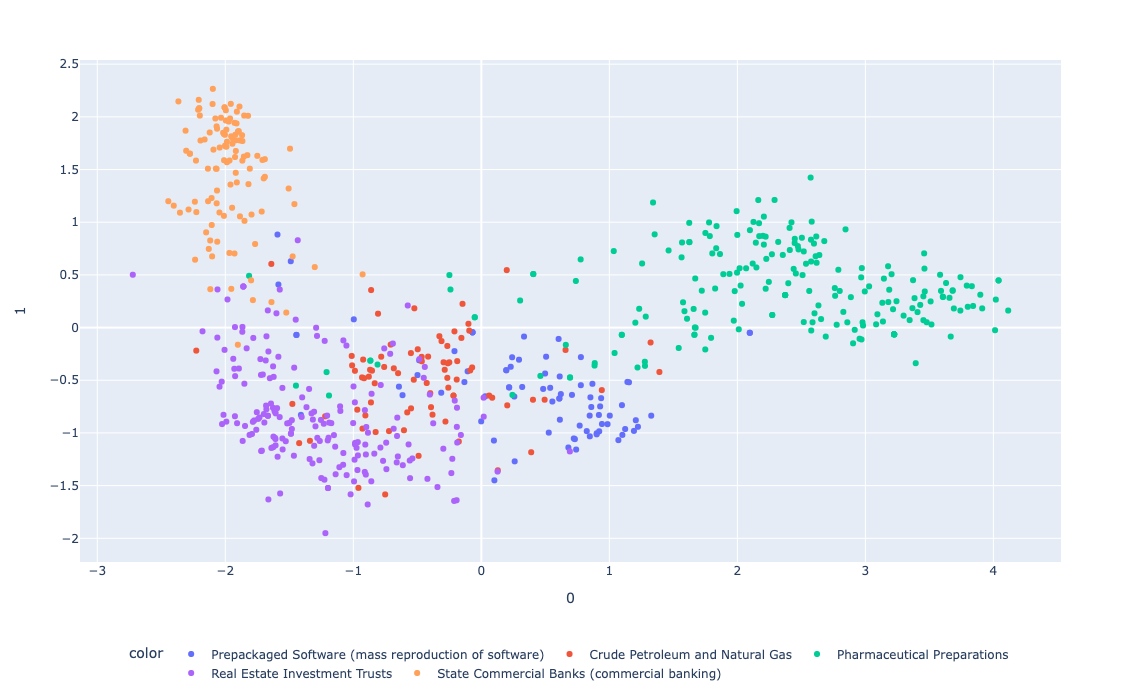

In [9]:
plot_pca = std_func.pca_visualize_2d(doc_vec, df.loc[:,["name","SIC_desc"]])

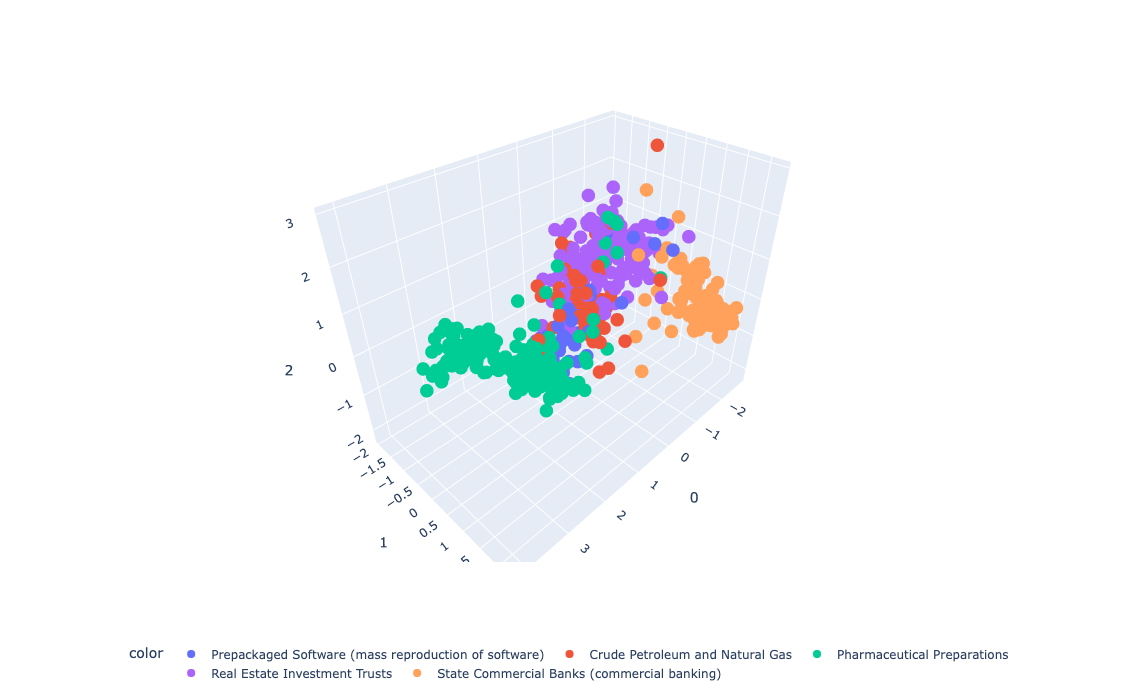

In [10]:
std_func.pca_visualize_3d(plot_pca)

conf_mat = std_func.conf_mat(tfidf,df)conf_mat = std_func.conf_mat(tfidf,df)As you can see, these company embeddings don't like quite that great in our reduced space. Perhaps they didn't capture the semantic meaning very well, or its accurate and the semantic embedding of many companies is very jumbled up and their industry classification isn't entirely correct.

##  Performance Evaluation 

/Users/richardye/Documents/GitHub/ubineer_nlp_research/content/richard/../std_func.py:161: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



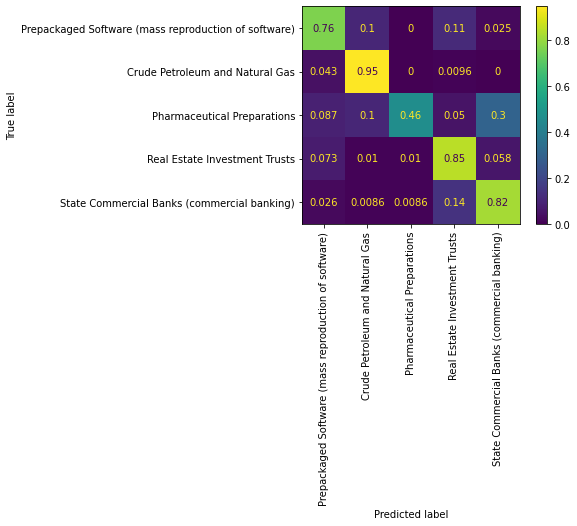

In [14]:
conf_mat = std_func.conf_mat(doc_vec,df)

In [15]:
dot_product_df, accuracy, cm = std_func.dot_product(doc_vec,df)
from sklearn.metrics import classification_report
print(classification_report(dot_product_df["y_true"], dot_product_df["y_pred"], target_names=df["SIC_desc"].unique()))

                                                      precision    recall  f1-score   support

Prepackaged Software (mass reproduction of software)       0.65      0.76      0.70        80
                     Crude Petroleum and Natural Gas       0.91      0.95      0.93       208
                         Pharmaceutical Preparations       0.93      0.46      0.62        80
                       Real Estate Investment Trusts       0.84      0.85      0.84       191
         State Commercial Banks (commercial banking)       0.72      0.82      0.77       116

                                            accuracy                           0.82       675
                                           macro avg       0.81      0.77      0.77       675
                                        weighted avg       0.83      0.82      0.81       675



/Users/richardye/Documents/GitHub/ubineer_nlp_research/content/richard/../std_func.py:161: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



From the confusion matrix and the classification report, we can conclude that the word2vec pseudo-company embedding does a poor job at classifying the category of the companies, except for the Crude Petroleum. This is in line with our observations of the PCA plots, as they did not do a very good job at separating companies in different industries.